<a href="https://colab.research.google.com/github/yuxizhe/HTML-UI-datasets-generate/blob/master/cv%E5%90%8E%E5%88%86%E7%B1%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget 'https://drive.google.com/uc?export=download&id=1XRBS9hxK4l1zMQuMNZuefa12r52yKwX2' -O pic.zip
!rm -rf pic
!unzip -q pic.zip

In [0]:
!pip install tf-nightly
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [0]:
# tesseract 中文识别

# 环境安装
! apt install tesseract-ocr
#加载中文语言包
! apt install tesseract-ocr-chi-sim

!pip install pillow
!pip install pytesseract

In [0]:
# 文字识别
import pytesseract
from pytesseract import Output

In [0]:
# 识别元素内及元素前的文字

def element_ocr(cropped, img, x, y, w, h):
  # 识别矩形中的文字
  inner_text = pytesseract.image_to_string(cropped, lang='chi_sim')
  print('元素内文字:  '+ inner_text)
  
  # 识别矩形前的文字 往前100
  textAreaBefore = img[y:y+h,max(0,x-300):x]
  cv2_imshow(textAreaBefore)
  # 识别前序文字
  before_text = pytesseract.image_to_string(textAreaBefore, lang='chi_sim')
  print('元素前区域文字：  '+before_text)

  return inner_text,before_text

In [0]:
!cp /content/drive/My\ Drive/Fast.io/ygd.imfast.io/PingFang.ttc /content/

In [0]:
# 中文字体显示
from PIL import Image, ImageDraw, ImageFont

def cv2ImgAddText(img, text, left, top, textColor=(255, 0, 255), textSize=15):
    if (isinstance(img, np.ndarray)):  #判断是否OpenCV图片类型
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img)
    fontText = ImageFont.truetype(
        "/content/PingFang.ttc", textSize, encoding="utf-8")
    draw.text((left, top), text, textColor, font=fontText)
    return cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)


In [0]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

#获取图片内矩形函数
def cv_get_block(location):
  img = cv2.imread(location)
  # img resize to 700
  img = cv2.resize(img, (700,int(700/img.shape[1]*img.shape[0])), interpolation=cv2.INTER_AREA)

  # 转为灰度
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # 边缘检测
  binary = cv2.Canny(gray,50,100)

  #cv2_imshow(binary)

  #检测轮廓
  # RETR_EXTERNAL  表示只检测最外层轮廓
  contours, hier = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # 裁剪出的图片
  croppedImage = []
  # 位置信息和文案信息
  positionAndText = []

  for c in contours:  #遍历轮廓
      rect = cv2.minAreaRect(c)  #生成最小外接矩形

      # 计算最小面积矩形的坐标
      # 这个返回坐标点顺序是随机的
      box = cv2.boxPoints(rect)
      box = np.int0(box)  # 将坐标规范化为整数

      h = int(abs(box[3, 1] - box[1, 1]))
      w = int(abs(box[3, 0] - box[1, 0]))
      y = min(box[2][1],box[0][1])
      x = min(box[2][0],box[0][0])

      # 去除太小太大 的矩形，只保留合适的
      if (h > 500 or w > 600):
          continue
      if (h < 20 or w < 60):
          continue
      
      #print(h,w)
      #print(box)
      # 取出图片
      # image[y:y+h, x:x+w]  
      cropped = img[y-5:y+h+5, x-5:x+w+5]

      print('\n 元素识别：')
      cv2_imshow(cropped)

      # 识别矩形中的文字
      inner_text, before_text = element_ocr(cropped, img, x, y, w, h)
      
      # 传出
      positionAndText.append([box,inner_text,before_text])
      
      # 格式化为正方形
      cropped = resize_image(cropped)
      croppedImage.append(cropped)
      # 绘制矩形
      cv2.drawContours(img, [box], 0, (255, 0, 255), 1)
  #cv2_imshow(img)

  # 输出 array 而不是list 
  # 'Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (224, 224, 3))
  # 因为 ImageDataGenerator.flow 输入为 NumpyArray
  return np.array(croppedImage), np.array(positionAndText), img

In [0]:
# 图像归一为 224 224
import os
import cv2
import glob
import numpy as np

min_side = 224

def resize_image(img):
    size = img.shape
    h, w = size[0], size[1]
    #长边缩放为min_side 
    scale = max(w, h) / float(min_side)
    new_w, new_h = int(w/scale), int(h/scale)
    resize_img = cv2.resize(img, (new_w, new_h))
    # 填充至min_side * min_side
    if new_w % 2 != 0 and new_h % 2 == 0:
        top, bottom, left, right = (min_side-new_h)/2, (min_side-new_h)/2, (min_side-new_w)/2 + 1, (min_side-new_w)/2
    elif new_h % 2 != 0 and new_w % 2 == 0:
        top, bottom, left, right = (min_side-new_h)/2 + 1, (min_side-new_h)/2, (min_side-new_w)/2, (min_side-new_w)/2
    elif new_h % 2 == 0 and new_w % 2 == 0:
        top, bottom, left, right = (min_side-new_h)/2, (min_side-new_h)/2, (min_side-new_w)/2, (min_side-new_w)/2
    else:
        top, bottom, left, right = (min_side-new_h)/2 + 1, (min_side-new_h)/2, (min_side-new_w)/2 + 1, (min_side-new_w)/2
    pad_img = cv2.copyMakeBorder(resize_img, int(top), int(bottom), int(left), int(right), cv2.BORDER_CONSTANT, value=[255,255,255]) #从图像边界向上,下,左,右扩的像素数目
    #print pad_img.shape
    #cv2.imwrite("after-" + os.path.basename(filename), pad_img)
    return pad_img


In [0]:
# 输出分类结果
import matplotlib.pyplot as plt
def result_show(image_batch, predicted_name):
  plt.figure(figsize=(15,15))
  plt.subplots_adjust(hspace=0.5)
  for n in range(len(predicted_name)):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_name[n].title())
    plt.axis('off')

In [0]:
# 在图片上显示结果
# 通过ImageDataGenerator.flow 后 顺序会变化
def result_show_in_image(img, boxes, predicted_name):
  newImage = img.copy()
  for index in range(len(boxes)):
    item = boxes[index]
    box = item[0]
    name = predicted_name[index]
    text = '组件: ' + name + ' ：'+ item[1] + '     before：'+ item[2]
    print('组件'+ str(index) + ': ' + text)
    # 中文字体显示
    newImage = cv2ImgAddText(newImage, text, min(box[2][0],box[0][0]) + 10, max(box[2][1],box[0][1]) - 30)
    # cv2.putText(newImage, name, (min(box[2][0],box[0][0]) + 10, max(box[2][1],box[0][1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (225,0,225), 1)
  cv2_imshow(newImage)

In [0]:
# 显示 ImageDataGenerator 处理后的图形
def show_batch(image_batch):
  plt.figure(figsize=(10,10))
  for n in range(len(image_batch)):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n].squeeze())
      # plt.title(CLASS_NAMES[int(label_batch[n])])
      plt.axis('off')

In [0]:
# 复制训练好的模型
!cp -rp /content/drive/My\ Drive/Fast.io/ygd.imfast.io/model/1589361295 /content/model/

In [0]:
# 加载模型
html_model = tf.keras.models.load_model('/content/model/')

In [0]:
# create a data generator
datagen = ImageDataGenerator(rescale=(1/255))


 元素识别：


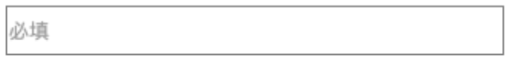

元素内文字:  


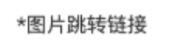

元素前区域文字：  *图片跳转链接

 元素识别：


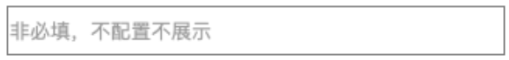

元素内文字:  非必填，不配置不展示


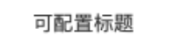

元素前区域文字：  可配置标题

 元素识别：


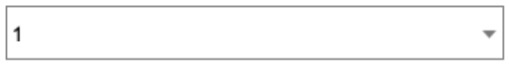

元素内文字:  


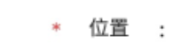

元素前区域文字：  位置

 元素识别：


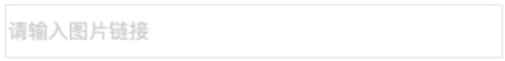

元素内文字:  请输入图片链接


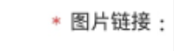

元素前区域文字：  * 图片链接 :

 元素识别：


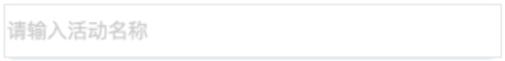

元素内文字:  请输入活动名称


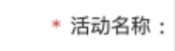

元素前区域文字：  * 活动名称 :

 元素识别：


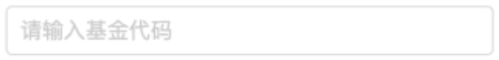

元素内文字:  请输入基金代码


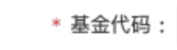

元素前区域文字：  * 基金代码 :
['Input' 'Input' 'Select' 'Input' 'Input' 'Input']
组件0: 组件: Input ：请输入图片链接     before：* 图片链接 :
组件1: 组件: Input ：请输入基金代码     before：* 基金代码 :
组件2: 组件: Select ：     before：位置
组件3: 组件: Input ：     before：*图片跳转链接
组件4: 组件: Input ：非必填，不配置不展示     before：可配置标题
组件5: 组件: Input ：请输入活动名称     before：* 活动名称 :


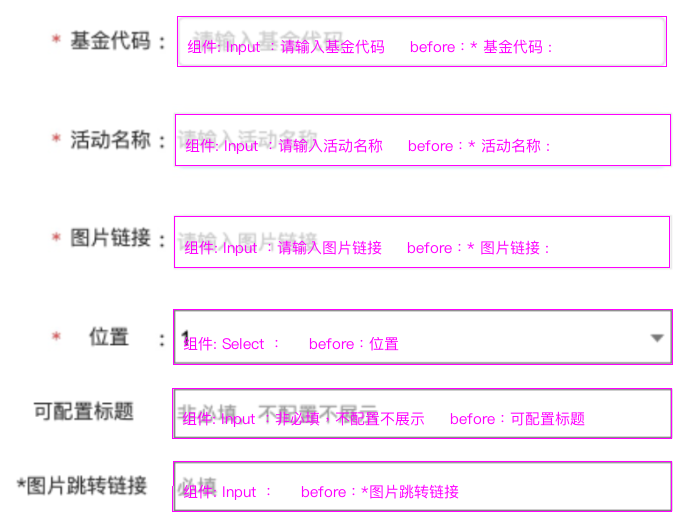

In [307]:
# 从图片CV获取元素
images,positionAndText ,img = cv_get_block('/content/截屏2020-05-15下午3.44.04.png')

# 矩形元素 通过ImageDataGenerator 图像进一步处理
# 需要注意的是，通过flow输出的数据是乱序的，并不会严格安装输入的顺序，所以对应关系要存储在label中
input_data = datagen.flow(images, positionAndText)
image_batch, boxes_batch = next(input_data)
# 预测元素
predicted_batch = html_model.predict(image_batch)

# 结果归一
predicted_id = np.argmax(predicted_batch, axis=-1)

class_name = np.array(['Input', 'Select', 'Button'])
# 结果对应上名字
predicted_name = class_name[predicted_id]
print(predicted_name)
# 图示结果
#result_show(image_batch, predicted_name)

result_show_in_image(img, boxes_batch, predicted_name)